# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

# Loading the dataset

## Define Dateloader

In [3]:
from src.Mydataloader import LoadDataset

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)

print("train.transforms =", train_data.transform, train_dataloader.batch_size)
print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------
train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = Compose(
      ToTensor()
      Submean()
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [5]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-5.4027e-09, -2.5610e-09, -2.5544e-09])
Shape of y: torch.Size([256]) torch.int64


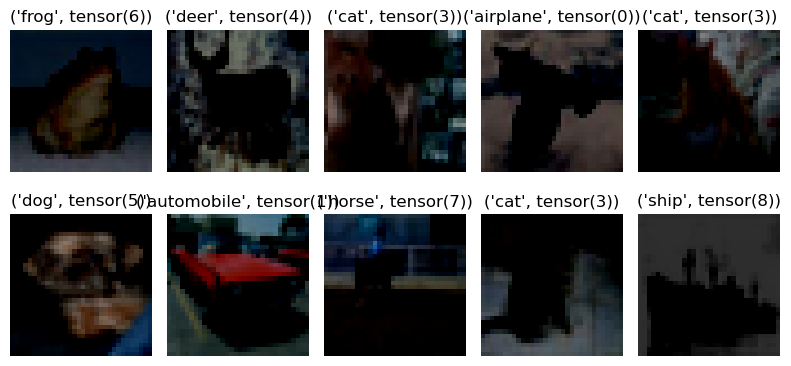

In [6]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [7]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [10]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [11]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [12]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [13]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

## Load before process

In [14]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True:
    if os.path.exists("logs/" + file_path + ".pth.tar"):
        # Read checkpoint as desired, e.g.,
        checkpoint = torch.load(
            "logs/" + file_path + ".pth.tar",
            map_location=lambda storage, loc: storage.cuda(device),
        )
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])
        logs = checkpoint["logs"]

        print("Suceessfully loaded the All setting and Log file.")
        print(file_path)
        print(f"Current epoch is {len(logs['valid_loss'])}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
        print(f"Current best validation loss: {best_val_loss:.4f}")
        print(f"Current early stopping counter: {early_stop_counter}")
        
    else:
        # Create a dictionary to store the variables
        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []
        test_loss = []
        test_acc = []

        logs = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "valid_loss": valid_loss,
            "valid_acc": valid_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
        print("File does not exist. Created a new log.")
        
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")
    

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_Adam_decay
Current epoch is 499
Current learning rate: 0.001
Current best validation loss: inf
Current early stopping counter: 0


In [15]:
# CHECK = 498
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]

# [Training Loop]

In [16]:
from src.Mytraining import DoTraining

In [17]:
if "Adam" in OPTIMIZER:
    Training = DoTraining(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        scheduler=None,
        device=device,
        logs=logs,
        file_path=file_path,
    )
else:
    Training = DoTraining(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        scheduler=scheduler,
        device=device,
        logs=logs,
        file_path=file_path,
    )
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        valid_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        valid_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 500/5000] :


100%|██████████| 186/186 [00:09<00:00, 19.74it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.0293 | Valid Acc: 99.24%
Test  Loss: 0.8625 | Test Acc: 81.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 501/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0344 | Valid Acc: 98.96%
Test  Loss: 0.8944 | Test Acc: 81.77%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 502/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.20it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.0442 | Valid Acc: 98.40%
Test  Loss: 0.9496 | Test Acc: 81.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 503/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0672 | Valid Acc: 97.44%
Test  Loss: 0.9546 | Test Acc: 80.97%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 504/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.35it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.2130 | Valid Acc: 92.84%
Test  Loss: 1.0830 | Test Acc: 78.65%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 505/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.36it/s]


Train Loss: 0.0004 | Train Acc: 96.43%
Valid Loss: 0.2188 | Valid Acc: 93.20%
Test  Loss: 1.1040 | Test Acc: 78.76%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 506/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.79it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.1464 | Valid Acc: 95.64%
Test  Loss: 0.9419 | Test Acc: 80.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 507/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.07it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.0967 | Valid Acc: 96.88%
Test  Loss: 0.9216 | Test Acc: 80.77%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 508/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.72it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.1389 | Valid Acc: 95.16%
Test  Loss: 0.9727 | Test Acc: 80.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 509/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.40it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.0895 | Valid Acc: 97.16%
Test  Loss: 0.9110 | Test Acc: 82.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 510/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.31it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.1150 | Valid Acc: 96.48%
Test  Loss: 0.9922 | Test Acc: 81.04%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 511/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.50it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.1846 | Valid Acc: 94.32%
Test  Loss: 0.9840 | Test Acc: 80.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 512/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.01it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2175 | Valid Acc: 93.04%
Test  Loss: 0.9395 | Test Acc: 80.74%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 513/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.73it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.1899 | Valid Acc: 93.96%
Test  Loss: 0.9036 | Test Acc: 80.97%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 514/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.35it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.1679 | Valid Acc: 94.96%
Test  Loss: 0.9143 | Test Acc: 81.79%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 515/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.52it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1296 | Valid Acc: 95.60%
Test  Loss: 0.8559 | Test Acc: 82.00%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 516/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1362 | Valid Acc: 95.56%
Test  Loss: 0.8743 | Test Acc: 82.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 517/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1787 | Valid Acc: 94.40%
Test  Loss: 0.9299 | Test Acc: 81.89%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 518/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.86it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.3097 | Valid Acc: 91.64%
Test  Loss: 1.1020 | Test Acc: 79.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 519/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.16it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.3078 | Valid Acc: 91.28%
Test  Loss: 0.9781 | Test Acc: 79.80%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 520/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.38it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2768 | Valid Acc: 91.64%
Test  Loss: 0.9078 | Test Acc: 80.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 521/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.73it/s]


Train Loss: 0.0003 | Train Acc: 99.29%
Valid Loss: 0.2588 | Valid Acc: 92.40%
Test  Loss: 0.8964 | Test Acc: 81.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 522/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.62it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2093 | Valid Acc: 93.96%
Test  Loss: 0.8854 | Test Acc: 82.01%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 523/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.71it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1906 | Valid Acc: 93.76%
Test  Loss: 0.9161 | Test Acc: 82.00%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 524/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.15it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.2049 | Valid Acc: 93.80%
Test  Loss: 0.9109 | Test Acc: 81.76%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 525/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.70it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.2996 | Valid Acc: 92.04%
Test  Loss: 1.0079 | Test Acc: 80.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 526/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.24it/s]


Train Loss: 0.0004 | Train Acc: 98.57%
Valid Loss: 0.4112 | Valid Acc: 88.72%
Test  Loss: 1.0579 | Test Acc: 78.71%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 527/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.43it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3696 | Valid Acc: 89.76%
Test  Loss: 0.9975 | Test Acc: 80.01%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 528/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.44it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2476 | Valid Acc: 92.32%
Test  Loss: 0.9182 | Test Acc: 82.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 529/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2643 | Valid Acc: 92.20%
Test  Loss: 0.8856 | Test Acc: 82.15%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 530/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2521 | Valid Acc: 92.88%
Test  Loss: 0.8645 | Test Acc: 82.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 531/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.20it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.3497 | Valid Acc: 91.24%
Test  Loss: 1.0591 | Test Acc: 79.55%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 532/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.92it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.5650 | Valid Acc: 86.20%
Test  Loss: 1.2479 | Test Acc: 77.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 533/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.06it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.4594 | Valid Acc: 88.08%
Test  Loss: 1.0912 | Test Acc: 78.70%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 534/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.24it/s]


Train Loss: 0.0004 | Train Acc: 98.57%
Valid Loss: 0.3346 | Valid Acc: 89.72%
Test  Loss: 0.8960 | Test Acc: 81.66%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 535/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3361 | Valid Acc: 90.52%
Test  Loss: 0.9465 | Test Acc: 81.60%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 536/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.68it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3258 | Valid Acc: 90.64%
Test  Loss: 0.9296 | Test Acc: 81.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 537/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3132 | Valid Acc: 91.12%
Test  Loss: 0.9068 | Test Acc: 82.08%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 538/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.12it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.3592 | Valid Acc: 90.40%
Test  Loss: 1.0203 | Test Acc: 81.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_Adam_decay.pth.tar]
--------------------------------------------------
[Epoch 539/5000] :


 26%|██▌       | 48/186 [00:02<00:06, 20.58it/s]


KeyboardInterrupt: 

## Training Results

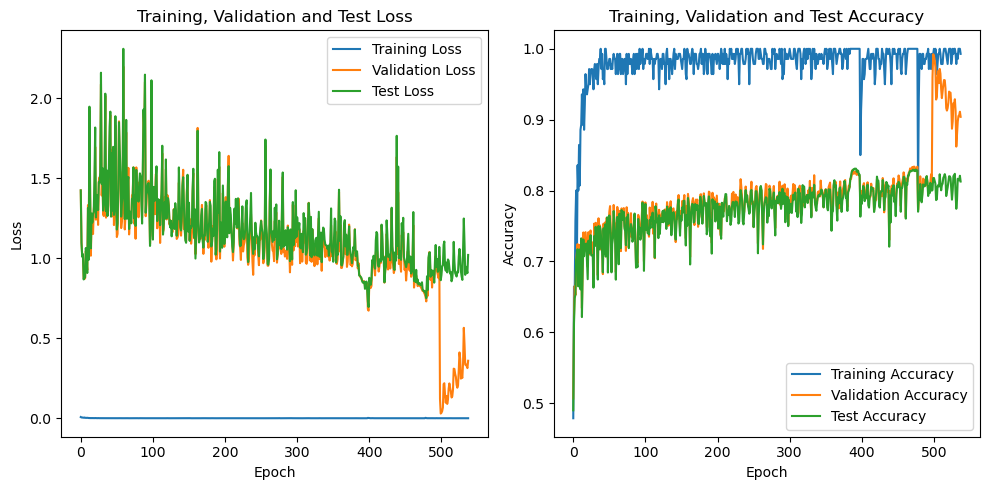

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [19]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

538
538
538
538
538
538


- 주피터노트북 output set
- @tag:notebookOutputLayout